In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import os

from typing import List, Tuple

%matplotlib inline

In [2]:
tf.__version__

'2.0.0-rc0'

In [3]:
train = pd.read_csv('../data/train_labels.csv')
example = train[:11][['x', 'y', 'width', 'height']]
example.width += example.x
example.height += example.y
example = example.values
example[:, [0, 2]] = np.round(example[:, [0, 2]] * 480/704)

# RPN
1. for each location i in a (H, W) grid:
    <p style="margin-left: 30px"> generate A anchor boxes centered on cell i
    </p>
3. remove predicted boxes with either height or width < threshold
4. sort all (proposal, score) pairs by score from highest to lowest
5. take the top pre_nms_topN proposals before NMS
6. apply NMS with a loose threshold (0.7) to the remaining proposals
7. take after_nms_topN proposals after NMS
8. return the top proposals

In [4]:
import sys
sys.path.append("..")

from vehicle_nowcasting.datasets.generate_anchors import generate_anchors
from vehicle_nowcasting.datasets.utils import *

In [5]:
def iou(bboxes1: np.ndarray, bboxes2: np.ndarray) -> np.ndarray:
    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    
    return iou

In [477]:
def plot_anchors(img: np.ndarray, anch: np.ndarray,
                 color: Tuple[int, int, int],
                 size: int = 1) -> np.ndarray:
    for i in range(len(anch)):
        img = cv2.rectangle(img, (anch[i, 0], anch[i, 1]), 
                                    (anch[i, 2], anch[i, 3]), color, size)                
    return img

In [484]:
img = cv2.cvtColor(cv2.imread('../data/train/15-02-15-20:17.jpg'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (480, 480)) 

pos_s = []
neg = []

anchors_cache = []

for dx in range(25):
    for dy in range(25):
        anchors = generate_anchors(base_size=4, ratios=[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
                                   scales=2 ** np.arange(3, 10))
        anchors = move_anchors(anchors.astype(int), 20 * dx, 20 * dy)
        anchors = anchors[((anchors > 0) & (anchors < 480)).all(axis=-1), :]
        
        if anchors.any():
            anchors_cache.append(anchors)
        
        iou_matrix = iou(anchors, example)
        if iou_matrix.any():
            cache = iou_matrix
        
        pos_s.append(anchors[(iou_matrix > 0.65).any(axis=1)])
        neg.append(anchors[(iou_matrix < 0.3).all(axis=1)])

slow = set()
for i in np.concatenate(anchors_cache):
    slow.add(str(i))

In [505]:
from itertools import product

delta = 20 * np.array(list(product(range(25),range(25))))
delta = np.hstack([delta, delta])
anchors = generate_anchors(base_size=4,
                           ratios=[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
                           scales=2 ** np.arange(3, 10))

anchors = anchors.reshape(-1, 4, 1) + np.zeros((*anchors.shape, delta.shape[0]))
anchors += delta.T.reshape(1, 4, -1)
anchors = anchors.transpose(2, 0, 1).reshape(-1, 4)
anchors = anchors[((anchors > 0) & (anchors < 480)).all(axis=-1), :]
iou_matrix = iou(anchors, example)
pos = anchors[(iou_matrix > 0.7).any(axis=1)]
neg = anchors[(iou_matrix < 0.3).any(axis=1)]

fast = set()
for i in anchors.astype(int):
    fast.add(str(i))

(-0.5, 479.5, 479.5, -0.5)

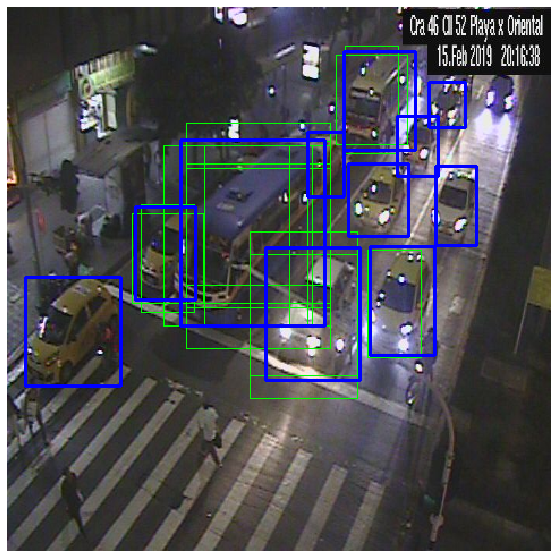

In [506]:
img = cv2.cvtColor(cv2.imread('../data/train/15-02-15-20:17.jpg'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (480, 480)) 

def plot_bb(img, org, color, size):
    for anch in org.astype(int):
        img = cv2.rectangle(img, (anch[0], anch[1]), 
                            (anch[2], anch[3]), color, size)
    return img

img = plot_bb(img, pos, (0, 255, 0), 1)
img = plot_bb(img, example, (0, 0, 255), 2)
        
plt.figure(figsize=(10, 10))
plt.imshow(img/255)
plt.axis('off')

In [498]:
img = cv2.cvtColor(cv2.imread('../data/train/15-02-15-20:17.jpg'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (480, 480)) 

color = (0, 255, 0)
size = 1

for anch in pos.astype(int):
    img = cv2.rectangle(img, 
                        (anch[0], anch[1]), 
                        (anch[2], anch[3]),
                        color, 
                        1)
    

In [253]:
np.concatenate(pos).shape

(816,)

In [254]:
pos

array([[110., 110., 273., 273.],
       [110., 102., 273., 281.],
       [130., 130., 273., 273.],
       [130., 122., 273., 281.],
       [138., 130., 265., 273.],
       [138., 122., 265., 281.],
       [138., 114., 265., 289.],
       [138., 106., 265., 297.],
       [150., 130., 253., 273.],
       [150., 150., 273., 273.],
       [150., 142., 273., 281.],
       [134., 118., 289., 305.],
       [158., 142., 265., 281.],
       [158., 134., 265., 289.],
       [158., 126., 265., 297.],
       [158., 118., 265., 305.],
       [154., 138., 289., 305.],
       [154., 122., 289., 321.],
       [154., 106., 289., 337.],
       [214., 198., 309., 325.],
       [218., 218., 325., 325.],
       [218., 202., 325., 341.],
       [234., 218., 309., 325.],
       [234., 202., 309., 341.],
       [106., 106., 277., 277.],
       [106., 102., 277., 281.],
       [110., 106., 273., 277.],
       [110., 102., 273., 281.],
       [126., 126., 277., 277.],
       [126., 122., 277., 281.],
       [13